In [1]:
from GeneratePolygons import *
import numpy as np
import matplotlib.pyplot as plt
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from itertools import combinations
%matplotlib inline

In [2]:
train_imgs=[]
train_labels=[] #the generating grammar, encoded as a space-separated string
sides_range=[3,4,5,6] #images will be polygons with number of sides being one of the numbers in this list

n_train=1500 #number of training images in each class
n_test=500


img_size=64
edge_length_range=(img_size/5,img_size/4)
center_mean=(img_size/2,img_size/2)
center_std=3
edge_width=2
params=dict({'img_size':img_size,'edge_length_range':edge_length_range,
            'center_mean':center_mean,'center_std':center_std,'edge_width':edge_width})


#generate images from the single-rule grammars
for class_id,n_sides in enumerate(sides_range):
    imgs=generate_batch(n_train,n_sides,**params)
    train_imgs.append(imgs)
    #the generative rules; T is used as terminal symbol; each ek corresponds to the relation between sides in k-sided polygon
    train_labels+=[(f'S -> S + e{n_sides} , S -> S + T')]*n_train
    

#now generate the combination grammars for all but one of the combinations
test_ids=(1,3)
test_sides=(sides_range[test_ids[0]],sides_range[test_ids[1]])
for i,j in combinations(sides_range,2):
    if (i,j)==test_sides or (i,j)==test_sides[::-1]:
        continue
    imgs=generate_batch_2rels(n_train,i,j,**params)
    train_imgs.append(imgs)
    train_labels+=[(f'S -> S + e{i} , S -> S + e{j} , S -> S + T')]*n_train
train_imgs=np.vstack(train_imgs)
train_labels=np.array(train_labels)

#discrete classes for multiclass problem
train_classes=np.vstack([[1*(f'e{s}' in x) for x in train_labels] for s in sides_range]).T

#use the held out combination for testing
test_imgs=generate_batch_2rels(n_test,test_sides[0],test_sides[1],**params)
test_labels=np.array([(f'S -> S + e{test_sides[0]} , S -> S + e{test_sides[1]} , S -> S + T')]*n_test)

#discrete classes for multiclass problem
test_classes=np.vstack([[1*(f'e{s}' in x) for x in test_labels] for s in sides_range]).T



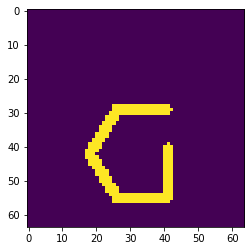

In [3]:
plt.imshow(test_imgs[np.random.choice(len(test_imgs))])

In [115]:
i0=np.random.choice(np.arange(4*n_train,5*n_train))
i1=np.random.choice(np.arange(7*n_train,8*n_train))
train_labels[i0],train_labels[i1]

('S -> S + e3 , S -> S + e4 , S -> S + T',
 'S -> S + e4 , S -> S + e5 , S -> S + T')

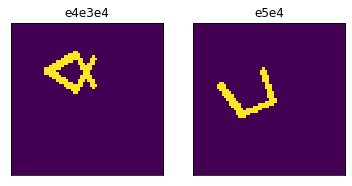

In [118]:
plt.subplot(1,2,1)
plt.title('e4e3e4')
plt.imshow(train_imgs[i0])
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title('e5e4')
plt.imshow(train_imgs[i1])
plt.xticks([])
plt.yticks([])
plt.savefig('/Users/Simon/Desktop/PolygonExample.pdf')

In [5]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)



In [6]:
TEXT.build_vocab([x.split(' ') for x in train_labels])

In [7]:
MAX_SEQ_LEN=24 #pad sequences so they are all this length

def str_to_int(s,max_len=MAX_SEQ_LEN):
    #s a string of tokens separated by spaces
    #return representation as sequence of integers
    #if length is < max_len, then add padding token at the end until it is this length
    char_as_int=[TEXT.vocab.stoi[x] for x in s.split(' ')]

    char_as_int=char_as_int[:MAX_SEQ_LEN]+[len(TEXT.vocab)]*max(MAX_SEQ_LEN-len(char_as_int),0) #pad
    return char_as_int
    
def str_to_onehots(s,max_len=MAX_SEQ_LEN):
    #s a string of tokens separated by spaces
    #return representation as sequence of one-hot vectors 
    #if length is < max_len, then add padding token at the end until it is this length
    
    char_as_int=str_to_int(s,max_len=max_len)


    ret=torch.zeros((max_len,len(TEXT.vocab)+1))
    for i,x in enumerate(char_as_int):
        ret[i,x]=1
    return ret

In [8]:
#convert each label to a sequence of one-hots
train_seqs=[str_to_int(x) for x in train_labels]
test_seqs=[str_to_int(x) for x in test_labels]


In [9]:
class GrammarGenerator(torch.nn.Module):
    def __init__(self):
        super(GrammarGenerator, self).__init__()
        # Convolution 1
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=1, padding=3)

        # Max pool 1
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=3)

        # Max pool 1
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        #dimensionality of lstm
        self.emb_dim=100
        self.h_dim=100 
        self.fc1=torch.nn.Linear(3240,self.emb_dim) 
        self.fc2=torch.nn.Linear(3240,self.h_dim)
        self.fc3=torch.nn.Linear(3240,self.h_dim)
        
        self.lstm = torch.nn.LSTM(self.emb_dim, self.h_dim)  
        self.tokenW=torch.nn.Linear(self.emb_dim+2*self.h_dim,len(TEXT.vocab)+1) #weights for decoding token from hidden state and embedding 

    def forward(self, x):
        #pass through conv layers
        outp=self.maxpool1(self.conv1(x))
        outp=torch.nn.ReLU()(outp)
        outp=self.maxpool2(self.conv2(outp))
        outp=torch.nn.ReLU()(outp)
        outp=torch.reshape(outp,(len(x),-1)) #concatenate so each image is represented by a 1d vector
        
        
        embs=[torch.nn.ReLU()(self.fc1(outp))[None,:,:]] #initialize lstm embedding  (extra axis for sequence dimsnion)
        
        h1s=[torch.nn.ReLU()(self.fc2(outp))[None,:,:]] #initialize lstm hidden state
        h2s=[torch.nn.ReLU()(self.fc3(outp))[None,:,:]]
        
        #run through lstm and record embeddings and hidden state
        for i in range(MAX_SEQ_LEN-1):
            new_emb,new_h=self.lstm(embs[-1],(h1s[-1],h2s[-1]))
            embs.append(new_emb)
            h1s.append(new_h[0])
            h2s.append(new_h[1])
        
        embs=torch.cat(embs,axis=0)
        h1s=torch.cat(h1s,axis=0)
        h2s=torch.cat(h2s,axis=0)
        
        #concatenate all together to decode the corresponding tokens
        features=torch.cat((embs,h1s,h2s),axis=2)
        
        features=self.tokenW(features) #logit for each token 
        
        
        return features.transpose(1,0) #reorder so batch dim is first

    
class ConvClassifier(torch.nn.Module):
    #same convolutional architecture but without the lstm
    #convolutional features fed directly to fully connected layer+sigmoid 
    def __init__(self,n_classes=len(sides_range)):
        super(ConvClassifier, self).__init__()
        # Convolution 1
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=1, padding=3)

        # Max pool 1
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=3)

        # Max pool 1
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        self.fc=torch.nn.Linear(3240,n_classes)

    def forward(self,x):
        #pass through conv layers
        outp=self.maxpool1(self.conv1(x))
        outp=torch.nn.ReLU()(outp)
        outp=self.maxpool2(self.conv2(outp))
        outp=torch.nn.ReLU()(outp)
        outp=torch.reshape(outp,(len(x),-1)) #concatenate so each image is represented by a 1d vector
        
        return torch.sigmoid(self.fc(outp))

In [10]:
model=GrammarGenerator()

In [11]:
batch_size=32
optimizer=torch.optim.SGD(model.parameters(),lr=.01)
criterion=torch.nn.CrossEntropyLoss()#weight=weights).to('cuda')
losses=[]


In [12]:
#train
for ii in range(12000):
    batch_ids = np.random.choice(train_imgs.shape[0], batch_size, replace=False)
    optimizer.zero_grad()

    feats=model(torch.from_numpy(train_imgs[batch_ids])[:,None,:,:].float())
    feats=feats.reshape(-1,feats.shape[2])
    #stack so that first axis is (first token in seq 1, ..., nth tokenin seq 1, first token in seq 2, ... nth in seq 2, ...)

    #list the token ids of the target sequences in the same order (first all seq1, then seq2, etc.)
    targets=torch.Tensor(sum([train_seqs[x] for x in batch_ids],[])).long()
    loss=criterion(feats, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    if(ii%25==0):
        print(losses[-1])

2.8210306
2.234571
2.0909991
2.0157099
1.7808646
1.6165172
1.5124445
1.3717328
1.2173682
1.2396739
1.1339902
1.0456333
1.040847
0.96139437
1.0068147
1.0181276
0.9284456
0.81148666
0.7258871
1.0664303
0.8857751
0.9517179
0.8621218
0.8331325
1.7450194
0.88885355
0.7323589
0.8158199
0.7119787
0.77415156
0.73284453
0.8543551
0.7531853
1.0474883
0.8520007
0.66971046
0.6326648
0.82798195
0.67891616
1.1073121
0.84964484
0.7967079
0.79904747
0.76036
0.75373554
0.6883529
0.8007517
0.7624304
0.68406516
0.7047464
0.68217444
0.6743717
0.6907129
0.6600104
0.72896546
0.6986408
0.71538216
0.5896239
0.59999496
0.71786433
0.70795757
0.63124317
0.7316758
0.62329656
0.6191825
0.6318774
0.6769588
0.61179835
0.61282283
0.75794667
0.76483434
1.1267533
0.91026926
0.84140253
0.82621366
0.69432956
0.6120325
0.8373845
0.7283342
0.67348844
0.6887796
0.65594906
0.67424875
0.7712622
0.72593045
0.7723293
0.5529372
0.56983346
0.59979004
0.5215164
0.6318398
0.6377217
0.5806709
0.47743413
0.6023055
0.5508754
0.6416389

(0, 0.2)

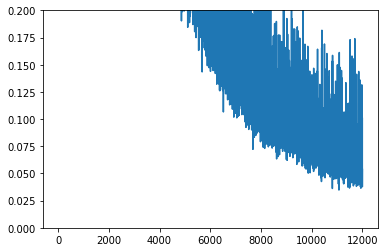

In [13]:

plt.plot(losses)
plt.ylim(0,.2)

In [14]:
#predictions on test images

In [15]:
predicted_grammars=[]

extended_vocab=TEXT.vocab.itos+['<pad>']
for x in test_imgs:
    outp=model(torch.from_numpy(x)[None,None,:,:].float()).squeeze()
    pred_seq=torch.argmax(outp,axis=1)
    pred_seq=[extended_vocab[c]+' ' for c in pred_seq]
    predicted_grammars.append(''.join(pred_seq))

In [128]:
#predicted grammars on randomly chosen test images
ids=np.random.choice(len(test_labels),10,replace=False) #pick some images randomly to show
[predicted_grammars[x] for x in ids] #predicted grammar for each image

['S -> S + e4 , S -> S + e5 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e5 , S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e5 , S -> S + e5 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e5 , S -> S + , , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + e5 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e3 , S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> <pad> <pad> ']

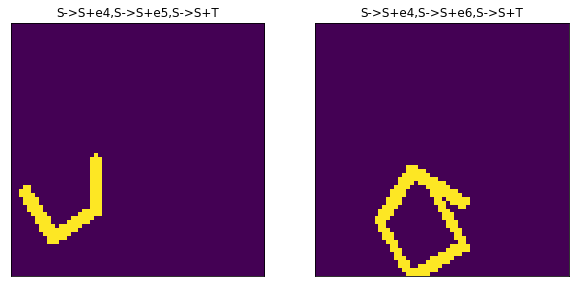

In [130]:

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(test_imgs[ids[i]])
    tokens=[x for x in predicted_grammars[ids[i]].split(' ') if x]
    #remove all the padding characters from the end
    #if there are any remaining padding characters not in a contiguous block at the end
    #then the grammar is invalid
    last_nonpad=len(tokens)-1 
    while(tokens[last_nonpad]=='<pad>'):
        last_nonpad-=1
    
    tokens=tokens[:last_nonpad+1]
    plt.title(''.join(tokens))
    plt.xticks([])
    plt.yticks([])
plt.savefig('/Users/Simon/Desktop/LSTM_outs.pdf')

In [17]:
#"partial credit": how many predicted grammars have at least one of the true testing symbols

#(for randomly guessing a pair of symbols, this probability will be 5/6)
np.mean([f'{test_sides[0]}' in predicted_grammars[i] or f'{test_sides[1]}' in predicted_grammars[i] for i in range(n_test)])

0.908

In [18]:
#"full credit": how many predicted grammars have both of the true testing symbols
#(for random guess: 1/6)
lstm_both_in_pred=np.mean([f'{test_sides[0]}' in predicted_grammars[i] and f'{test_sides[1]}' in predicted_grammars[i] for i in range(n_test)])

lstm_both_in_pred

0.258

In [19]:
#"partial credit": how many predicted grammars have the first test symbol
#(random guess: 1/2)
np.mean([f'{test_sides[0]}' in predicted_grammars[i] for i in range(n_test)])

0.562

In [20]:
#"partial credit": how many predicted grammars have the second testi symbols
#(random guess: 1/2)
np.mean([f'{test_sides[1]}' in predicted_grammars[i] for i in range(n_test)])

0.604

In [21]:
#"false alarms": how often the grammars contain symbols they shouldn't
non_test_sides=[x for x in sides_range if x not in test_sides]

In [22]:
#hit rate for first non test symbol
#lower is better 
#(chance=1/2)
np.mean([f'{non_test_sides[0]}' in predicted_grammars[i] for i in range(n_test)])

0.142

In [23]:
#for second
np.mean([f'{non_test_sides[1]}' in predicted_grammars[i] for i in range(n_test)])

0.558

In [37]:
#proportion with correct grammar (gets both of true symbols, and neither of decoy symbols)
np.mean([f'{test_sides[0]}' in predicted_grammars[i] and f'{test_sides[1]}' in predicted_grammars[i]
         and f'{non_test_sides[0]}' not in predicted_grammars[i] and f'{non_test_sides[1]}' not in predicted_grammars[i]
         for i in range(n_test)])

0.258

In [24]:
#now train the convolutional baseline w multiclass loss


model_baseline=ConvClassifier()
optimizer_baseline=torch.optim.SGD(model_baseline.parameters(),lr=.01)
criterion_baseline=torch.nn.BCELoss()
losses2=[]

In [25]:
#train
for ii in range(12000):
    batch_ids = np.random.choice(train_imgs.shape[0], batch_size, replace=False)
    optimizer_baseline.zero_grad()

    preds=model_baseline(torch.from_numpy(train_imgs[batch_ids][:,None,:,:]).float())
    targets=torch.from_numpy(train_classes[batch_ids]).float()
    loss=criterion_baseline(preds, targets)
    loss.backward()
    optimizer_baseline.step()
    losses2.append(loss.detach().numpy())
    if(ii%25==0):
        print(losses2[-1])

2.489363
0.67324173
0.5947574
0.61243194
0.58983517
0.5655147
0.5599623
0.5961701
0.5801622
0.61044985
0.5225509
0.53857994
0.66310054
0.5056512
0.59433997
0.58430594
0.55896187
0.45945126
0.53689015
0.56533426
0.45831847
0.54577285
0.4927764
0.46945524
0.46249336
0.51604956
0.47378772
0.4601757
0.49442655
0.41300902
0.47995356
0.40643483
0.41732034
0.38607544
0.5000163
0.5101394
0.3837981
0.41671747
0.4667412
0.42033958
0.4862508
0.3865807
0.38858655
0.3520615
0.4863602
0.48546427
0.44350845
0.44698343
0.4203392
0.3034929
0.4170139
0.3825639
0.48261157
0.4134204
0.4253461
0.441216
0.35793045
0.42716104
0.3868441
0.35158893
0.40488178
0.4116907
0.31797302
0.3641966
0.41377184
0.28733468
0.3981366
0.3452239
0.34899712
0.36974302
0.37352988
0.44189304
0.365942
0.40575156
0.33429947
0.3597132
0.32594973
0.33360043
0.38820747
0.32956526
0.26724294
0.36130184
0.33875126
0.38283998
0.41371828
0.39959678
0.4229856
0.32889715
0.40625283
0.33289677
0.3655404
0.4101976
0.3132359
0.2695749
0.2996

(0, 2)

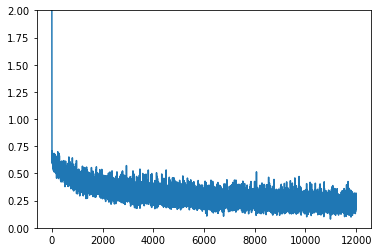

In [26]:
plt.plot(losses2)
plt.ylim(0,2)

In [27]:
#multiclass predictions on test images
baseline_preds=model_baseline(torch.from_numpy(test_imgs[:,None,:,:]).float()).detach().numpy()




In [28]:
#we can form a grammar based on the multiclss predictions by first selecting a threshold T
#and including the corresponding production rules if the activation of the unit in th prediction
#exceeds T

#in order to compare with the LSTM, we first choose T to achieve the same proportion of images
#in which both of the correct symbols are picked

#we then compute the false alarm rates using this T (i.e. how often an incorrect symbol is picked)
#and compare to the LSTM




In [29]:

#compute the threshold value that matches the true hit rate for lstm


thresh_range=np.linspace(0,1,200) 
true_hits=[np.mean(np.logical_and(baseline_preds[:,test_ids[0]]>thresh,baseline_preds[:,test_ids[1]]>thresh)) for thresh in thresh_range]
thresh=thresh_range[np.argmin(np.abs(np.array(true_hits)-lstm_both_in_pred))]

In [30]:
#how many have either of the true symbols
np.mean(np.logical_or(baseline_preds[:,test_ids[0]]>thresh,baseline_preds[:,test_ids[1]]>thresh))

0.972

In [31]:
#how many predictions have both of the true symbols (should match the number for lstm)
np.mean(np.logical_and(baseline_preds[:,test_ids[0]]>thresh,baseline_preds[:,test_ids[1]]>thresh))

0.26

In [32]:
#each true symbol individually 
np.mean(baseline_preds[:,test_ids[0]]>thresh)

0.652

In [33]:
np.mean(baseline_preds[:,test_ids[1]]>thresh)

0.58

In [34]:
#the class ids for the production rules not in the test grammar
non_test_ids=[i for i in range(len(sides_range)) if i not in test_ids]


In [35]:
#how many predictions have a false symbol (lower is better)
np.mean(baseline_preds[:,non_test_ids]>thresh)

0.685

In [36]:
np.mean(baseline_preds[:,test_ids]>thresh)

0.616

In [53]:
#the maximal proportion of examples which have the correct classification profile, over all threshold values
#(both of the true symbols are above the threshold, and both of the decoy ones are below)
max([np.mean(np.logical_and(np.logical_and(baseline_preds[:,test_ids[0]]>thresh,baseline_preds[:,test_ids[1]]>thresh),
                np.logical_and(baseline_preds[:,non_test_ids[0]]<thresh, baseline_preds[:,non_test_ids[1]]<thresh))) for
thresh in thresh_range])

0.02

In [69]:
#checking how many of the generated grammars are syntactically valid

def valid_grammar(g):
    #given a string, check if it is syntactically valid grammar
     
    tokens=[x for x in g.split(' ') if x]
    #remove all the padding characters from the end
    #if there are any remaining padding characters not in a contiguous block at the end
    #then the grammar is invalid
    last_nonpad=len(tokens)-1 
    while(tokens[last_nonpad]=='<pad>'):
        last_nonpad-=1
    
    tokens=tokens[:last_nonpad+1]
    if('<pad>' in tokens):
        return False
    
    comma_blocks=''.join(tokens).split(',')
    #each of the elements in comma blocks must equal one of the 5 valid production rules
    #also the termination condition must appear in coma_blocks
    
    valid_rules=['S->S+T']+[f'S->S+e{s}' for s in sides_range]
    return all([x in valid_rules for x in comma_blocks]) and valid_rules[0] in comma_blocks


In [76]:
np.mean([valid_grammar(x) for x in predicted_grammars])

0.96

In [132]:
#proportion of grammars containing each symbol
[np.mean([f'{j}' in predicted_grammars[i] for i in range(n_test)]) for j in sides_range]

[0.142, 0.562, 0.558, 0.604]